<a href="https://colab.research.google.com/github/DGkurnia/discuss1/blob/main/bmlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tahap Awal**
# Nama : Derfansyah Guswiranata Kurnia
# email : weerakurnia@gmail.com
# Identitas dicoding : dgkurnia
# Domisili : Jakarta Timur

In [1]:
#Inspeksi tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping as es


In [2]:
#Initiasi perpustakaan dasar
import numpy as np
from google.colab import files

#perpustakaan untuk inspeksi (Bagian matplotlib)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#Lanjutan impor perpustakaan
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse

#eksekusi file
from google.colab import drive
drive.mount('/content/gdrive')
import zipfile,os
#lanjutan perpustakaan
import time

Mounted at /content/gdrive


In [3]:
#inspeksi GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPU available.")

No GPU available.


** Fasa upload berkas**

In [4]:
#Persiapan filr dari github untuk ekstraksi
!wget -O janken.zip https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
!ls
#ekstraksi File
!unzip janken.zip


Streaming output truncated to the last 5000 lines.
  inflating: rockpaperscissors/scissors/KNNsNhduqSfuqEK5.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflating: rockpaperscissors/scissors/7dBQ0fOpCs03OmnR.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._7dBQ0fOpCs03OmnR.png  
  inflating: rockpaperscissors/scissors/DXQaN15KphkE4i7z.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._DXQaN15KphkE4i7z.png  
  inflating: rockpaperscissors/scissors/0CSaM2vL2cWX6Cay.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._0CSaM2vL2cWX6

In [5]:
# Inisiasi proyek
import os
#Daftar data
kertascol = '/content/rockpaperscissors/paper'
batucol = '/content/rockpaperscissors/rock'
guntingcol = '/content/rockpaperscissors/scissors'
colasli = '/content/rockpaperscissors/rps-cv-images' #Jalur dokumen asli

#deklarasi variable os deklarasi daftar
listdirkert = os.listdir(kertascol) #kertas
listdirbatu = os.listdir(batucol) #batu
listdirgunting = os.listdir(guntingcol) #gunting
listdirvalid = os.listdir(colasli) #validasi gambar

# persiapan data
print("total data gunting", len(listdirkert))
print("total data kertas", len(listdirbatu))
print("total data batu", len(listdirgunting))
print("total data validasi", len(listdirvalid))

total data gunting 712
total data kertas 726
total data batu 750
total data validasi 4


**Eksekusi Awal**

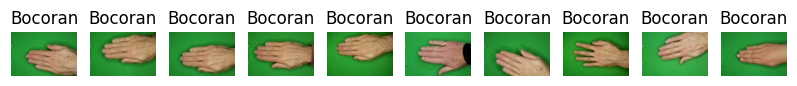

In [6]:
#Identifikasi gambar tahap awal
baris = 10
kolom = 10

#pembuatan file file gambar kertas untuk lima jenis file gambar berbeda
filegmb = [a for a in listdirkert if a.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
#intip 10 gambar pertama (ilustrasi grafik)
plt.figure(figsize=(10, 10))
#iterasi 10 gambar pertama (variable bocoran)
bocoran = enumerate(filegmb[:10])
#iterasi sesunguhnya
for a, filegmb in bocoran :
  jlrgmb = os.path.join(kertascol, filegmb)
  gmb = mpimg.imread(jlrgmb) #Untuk inspeksi gambar
  #Bagian sub grafik
  plt.subplot(baris, kolom, a+1)
  plt.imshow(gmb)
  plt.title('Bocoran')
  plt.axis('off')#mema
  #penampilan bocoran
plt.show()

**persiapan data latihan & data validasi**

In [7]:
#Tahap awal melalui Image Data Generator (IDG) bagian impor perpustakaan
import tensorflow as tf #Bagian tensor flow
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg
from tensorflow.keras.optimizers import RMSprop as rmsp
import gc
#Modifikasi generator dengan normalisasi
img_latihan = idg(
    rescale=1./255,  # Normalisasi pixel ke rentang [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='wrap',
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.4  # Nilai validasi adalah 40 persen
)
img_val = idg(
    rescale=1./255,  # Normalisasi pixel ke rentang [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='wrap',
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.4  # Nilai validasi adalah 40 persen
)


In [8]:
#Fasa latihan dengan imagedatagenerator (Eksekusi sesi latihan)
seksi_latihan = img_latihan.flow_from_directory(
    colasli,
    target_size=(150, 150), #ukuran 150*150
    batch_size=32, seed=50,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
#konstruksi validasi (latihan)
seksi_validasi = img_val.flow_from_directory(
    colasli,
    target_size=(150, 150),
    batch_size=32, seed=50,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
#eksekusi generator sebelum lanjut ke tahap selanjutmya

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


**Fasa dua**

In [21]:
#Persiapan perpustakaan
from tensorflow.keras import layers
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ReLU
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers as reg


# Penetapan ukuran
lbr_gmb = 150
tgi_gmb = 150  # Lebar dan tinggi

#kelas 'batch adaftif'
class AdaptiveBatchNormalization(layers.BatchNormalization):
    def call(self, inputs, training=None):
         if training is None:
            training = tf.keras.backend.learning_phase() # Infer training phase from Keras backend
         if training:
            return super().call(inputs, training=training)
         else:
            # Penrapan 'rata-rata bergerak'
            return super().call(inputs, training=False)
#ke eksekusi sekuensi

In [ ]:
#sekuensi
kerasmod = tf.keras.models.Sequential([
    # Layer 32 with ReLU
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid',
                           input_shape=(lbr_gmb, tgi_gmb, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    AdaptiveBatchNormalization(),

    # Layer 64 with ReLU
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    AdaptiveBatchNormalization(),

    # Layer 128 with ReLU
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='valid'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.LayerNormalization(),

    # Layer 256 with ReLU
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='valid'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Layer 512 with ReLU
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='valid'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),


    # Flatten the output before feeding into dense layers
    tf.keras.layers.Flatten(),

    # Dropout for regularization
    tf.keras.layers.Dropout(0.60),

    # Fully connected layer with ReLU
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(),

    # Output layer for classification
    tf.keras.layers.Dense(3,activation='softmax',kernel_regularizer= reg.L1L2(l1=2e-5, l2=2e-5)) #Ada lima kelas
])

# Summary of the model
kerasmod.summary()

**Bagian tiga**
##Kompilasi dan Penyesuaian
###Komposisi
- a. persiapan laju pembelajaran
- b. penyesuaian

In [23]:
#Perpustakaan kompilasi
from keras.losses import CategoricalFocalCrossentropy as catfoscent
from keras.metrics import Precision, Recall
# Eksekusi Kompilasi dan penyesuaian (Dinamisasi kelas).
class DynamicFocalLoss(catfoscent):
    def __init__(self, alpha=0.45, gamma=2.7, **kwargs):
        super().__init__(alpha=alpha, gamma=gamma, **kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def update_params(self, alpha=None, gamma=None):
        if alpha is not None:
            self.alpha = alpha
        if gamma is not None:
            self.gamma = gamma
#Lanjut ke bagian selanjutnya

In [24]:
#Bagian 2
class DynamicPrecision(Precision):
    def __init__(self, threshold=0.551, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def update_params(self, current_precision):
        if current_precision < 0.85:
            self.threshold -= 1e-4  # More aggressive decrease
        else:
            self.threshold += 1e-5  # Slightly increase threshold
#Bagian recall
class DynamicRecall(Recall):
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def update_params(self, current_recall):
        if current_recall < 0.5:
            self.threshold -= 1e-4  # More aggressive decrease
        else:
            self.threshold += 1e-5  # Slightly increase threshold
#Eksekusi kompilasi

In [25]:
#persiapan treshold
from datetime import datetime
#treshold
accuracy_threshold = 0.95
class MyCallbacks(tf.keras.callbacks.Callback):
    def __init__(self, max_time_minutes=30):
        super().__init__()
        self.max_time_minutes = max_time_minutes
        self.start_time = None

    def on_train_begin(self, logs=None):
        # Record the start time when training begins
        self.start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        # Calculate elapsed time
        elapsed_time = (datetime.now() - self.start_time).total_seconds() / 60.0

        # Check if accuracy meets the threshold
        if logs.get('accuracy') is not None:
            if logs['accuracy'] >= accuracy_threshold:
                print(f'\nFor Epoch {epoch + 1}, Accuracy has reached {logs["accuracy"] * 100:.2f}%. Training has been stopped.')
                self.model.stop_training = True

        # Check if maximum time limit has been exceeded
        if elapsed_time > self.max_time_minutes:
            print(f'\nFor Epoch {epoch + 1}, Training has exceeded the time limit of {self.max_time_minutes} minutes. Stopping training.')
            self.model.stop_training = True

In [26]:
#Eksekusi Kompilasi sessungguhnya (Insiasi metrik loss dinamik)
dynamic_loss = DynamicFocalLoss(alpha=0.45, gamma=2.70)
dynamic_precision = DynamicPrecision()
dynamic_recall = DynamicRecall()
#Ke deklarasi

In [27]:
#Persiapan laju penyesuaian (Deklarasi laju)
jadwal = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=7500, decay_rate=0.005,
    staircase=True
)
#Deklarasi optimasi
jadopti = tf.keras.optimizers.Adam(learning_rate=jadwal) #Jadwal optimasi
#Pemanggilan kembali tensor
pangiltensor = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
escallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 7, min_delta= 6e-10, restore_best_weights=True) #kesabaran inspeksi
mccallback = tf.keras.callbacks.ModelCheckpoint(filepath='model_best.keras', monitor='val_accuracy', save_best_only=True) #model checkpoint callback

**Persiapan penyesuaian**

In [28]:
#Kelas 'Dataset Kustom' dan Dinamisasi epoch  (Definisi hasil kelas (adjust this according to your dataset))
num_classes = 3  # Nilai terdiri dari batu gunting kertas
#Dinamisasi parameter
EPOK = 20  # Number of epochs
batch_size = 30  # Definisi Epok

# Dinamisasi Epok
steps_per_epoch = len(seksi_latihan) // batch_size #Aspek langkah per epoch
validation_steps = len(seksi_validasi) // batch_size #Aspek ukuran

# Callback for dynamic epoch adjustment based on AUC
class DynamicEpochs(tf.keras.callbacks.Callback):
    def __init__(self, patience=8):
        super().__init__()
        self.patience = patience
        self.best_auc = 0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_auc = logs.get('val_auc')
        if current_auc is not None:
            if current_auc > self.best_auc:
                self.best_auc = current_auc
                self.wait = 0
            else:
                self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping at epoch {epoch + 1} due to no improvement in AUC.")
                self.model.stop_training = True
  # Instantiate the callback
dynamic_epochs_callback = DynamicEpochs(patience=8)
#instansi batas waktu
my_callbacks_instance = MyCallbacks(max_time_minutes=30)

In [29]:
# Eksekusi keras mod
kerasmod.compile(
    loss=dynamic_loss,
    optimizer='adam',
    metrics=['accuracy', dynamic_precision, dynamic_recall, 'AUC'],
    run_eagerly=True,
)

In [30]:
#dinamisasi verbose
import logging
import argparse

# Persiapan
def parse_args():
    parser = argparse.ArgumentParser(description="Set logging level.")
    parser.add_argument('--log', '-l', default='WARNING', help='Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)')
    return parser.parse_known_args()  # Change here

# Penyetelan
args, unknown = parse_args()  # Inspeksi Argumen tanpa nama
logging.basicConfig(level=args.log)

# Optionally print unrecognized arguments for debugging
if unknown:
    print("Unrecognized arguments:", unknown)


Unrecognized arguments: ['-f', '/root/.local/share/jupyter/runtime/kernel-d89e5b0a-13cf-4834-8027-59bf3586ed09.json']


In [ ]:
#Persiapan Epoch (Pembuatan almanak gambar)
almanak = kerasmod.fit(
    seksi_latihan,  # Hal ini mewakili seksi latihan
    epochs=EPOK,
    batch_size= batch_size, #Nilai sudah didinamisasi
    validation_data = seksi_validasi,  # Changed to keyword argument
    callbacks=[pangiltensor, escallback, mccallback, dynamic_epochs_callback, my_callbacks_instance],
    verbose=10 if args.log == 'DEBUG' else 0  # Penataan verbose
)
#hasil (Inspeksi akurasi selama epok) di bawah
epokinsp = {'nilai akurasi': np.round(almanak.history['accuracy'],3),'nilai val_akurasi ': np.round(almanak.history['val_accuracy'],3),
    'lenyap ': np.round(almanak.history['loss'],3),'nilai val_lenyap': np.round(almanak.history['val_loss'],3)}
#Nilai Epok
print(epokinsp)

**Bagian empat: Cek akurasi**

In [32]:
#Bagian 1: Eksodus evaluasi dengan kondisional di sejarah almanak
import numpy as np #Pembulatan <)
if 'val_loss' in almanak.history:  # Inspeksi nilai hilang selama inspeksi
    # Evaluasi model almanak di latohan dan validasi
    akurasi = np.round(kerasmod.evaluate(seksi_latihan),3)  # Hasil Akurasi
    hilang = np.round(kerasmod.evaluate(seksi_validasi),3)  # Hasil hilang
    # Mencetak hasil
    print("Total hilang:", hilang, "Total akurasi:", akurasi)
else:
    print("Tak perlu validasi :)")
#Hasil di sini

28/28 [==============================] - 7s 254ms/step - loss: 0.3354 - accuracy: 0.8330 - dynamic_precision: 0.8339 - dynamic_recall: 0.8330 - auc: 0.9389
Total hilang: [0.335 0.833 0.834 0.833 0.939] Total akurasi: [0.324 0.831 0.833 0.83  0.936]


**Inspeksi Visual Hasil Epok via Matplotlib**

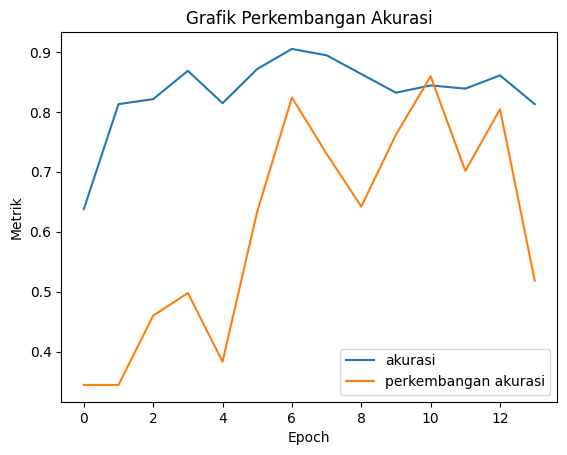

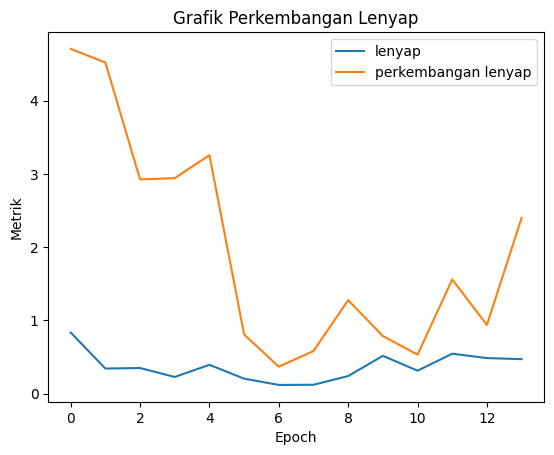

In [33]:
#hasil pemeriksaan akurasi dan lenyap di grafik bawah (Bagian impor sudah dilakukan)
plt.plot(almanak.history['accuracy'], label='akurasi')
plt.plot(almanak.history['val_accuracy'], label='perkembangan akurasi')
plt.title('Grafik Perkembangan Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Metrik')
plt.legend()
plt.show()
#Perkembangan lenyap di fasa asli dan validasi
plt.plot(almanak.history['loss'], label='lenyap')
plt.plot(almanak.history['val_loss'], label='perkembangan lenyap')
plt.title('Grafik Perkembangan Lenyap')
plt.xlabel('Epoch')
plt.ylabel('Metrik')
plt.legend()
plt.show()

In [ ]:
#Penyimpanan model
kerasmod.save('danxhmodelv1,3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Bagian 5: Proses sebenarnya

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = kerasmod.predict(images, batch_size=10)
  print(fn)

  print(fn)
  if classes[0][0] == 1:
    print('Paper')
  elif classes[0][1] == 1:
    print('Rock')
  else:
    print('Scissor')